# CIS 5200: Machine Learning
## Homework 4

In [1]:
import os
import sys

# For autograder only, do not modify this cell.
# True for Google Colab, False for autograder
NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")
    sys.exit()

[INFO, OK] Google Colab.


In [2]:
# %%capture
!pip install penngrader-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.1 MB/s eta 0:00:00


In [3]:
%%writefile config.yaml
grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Writing config.yaml


# You will work with the MNIST dataset in this howework.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [5]:
transformation = transforms.Compose([transforms.ToTensor(), torch.flatten])

train_set = MNIST('./data', train=True, download=True, transform=transformation)
test_set = MNIST('./data', train=False, download=True, transform=transformation)

train_loader = DataLoader(train_set, batch_size=1024, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=1024, shuffle=False, num_workers=0)

100%|██████████| 9912422/9912422 [00:00<00:00, 105001101.75it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21074407.42it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24813488.32it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4788971.54it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



training set is 60000 x 784
test     set is 10000 x 784


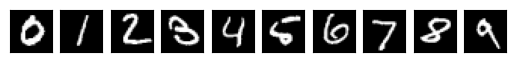

In [6]:
print("training set is {:d} x {:d}".format(60000, 28 * 28))
print("test     set is {:d} x {:d}".format(10000, 28 * 28))

fig, axes = plt.subplots(1, 10)
for i in range(10):
    indices = test_set.targets == i
    img = test_set.data[indices][0]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()

# Question 1: Fully Connected Neural Network (10 points)

Implement a fully connected neural network using `torch.autograd` and `torch.nn`.

1. (4 points) Implement the `Network` class by completing `__init__` and `forward` functions.
This is an one-hidden-layer ReLU network with the forward pass computed as
$$
f(\mathbf{x}) = \mathbf{W}_2 \operatorname{ReLU}(\mathbf{W}_1\mathbf{x} + \mathbf{b}_1) + \mathbf{b}_2.
$$
    - You can use `torch.nn.Linear` to help you implement the fully connected layer.
    - You can use `torch.nn.functional.relu` to implement the activation function.
    - Do not apply the softmax function on the network's output. You should strictly follow the above formula to implement the `forward` function, since the output of this function is the **pre-softmax** logits.
2. (2 points) Implement the `evaluate` function. This function computes the accuracy on the training/test set.
3. (4 points) Implement the `train` function. This function minimizes the cross entropy loss (a generalization of the logistic loss for multi-class classification) on the training set by stochastic gradient descent. You can compute the gradient using PyTorch autograd engine.


In [7]:
class Network(nn.Module):
    def __init__(self, in_dim, hidden, out_dim):
        super().__init__()

        # Start of the implementation
        self.fc1 = nn.Linear(in_dim, hidden)
        self.fc2 = nn.Linear(hidden, out_dim)
        self.relu = nn.ReLU()
        # End of the implementation

    def forward(self, x):
        # Start of the implementation
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        # End of the implementation

Implement `evaluate` and `train` function.
You `train` function should print the test accuracy in every epoch.

In [8]:
@torch.no_grad()
def evaluate(model, loader):
    """
    Evaluate the model accuracy on the training/test set by looping over the data loader.

    Args:
        model: a neural network
        loader: a PyTorch data loader

    Returns:
        (a float scalar) the accuracy on the training/test set
    """
    model.eval()

    correct = 0.
    total = 0.

    for x, y in loader:
        # Start of the implementation
        outputs = model(x)
        _, pred = torch.max(outputs, 1)
        total += y.shape[0]
        correct += (pred == y).sum().item()
        # End of the implementation

    return correct / total


def train(model, optimizer, train_loader, test_loader, epoch=20):
    """
    Train the neural network.

    Args:
        model: a neural network
        train_loader: a PyTorch data loader on the training set
        test_loader: a PyTorch data loader on the test set
        epoch: the number of epochs

    Returns:
        None, the model is updated in-place
    """
    model.train()

    # we use the cross entropy loss for classification
    criterion = nn.CrossEntropyLoss()

    # Start of the implementation
    for i in range(epoch):
      for j, (input, label) in enumerate(train_loader, 0):
        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
      acc_test = evaluate(model, test_loader)
      print("Epoch",i," test accuracy:",acc_test)
    # End of the implementation

def visualize(model):
    idx = torch.randint(high=10000, size=(1,)).item()

    print("image index {:d}".format(idx))

    img = test_set.data[idx]
    x = img.flatten().float()

    prediction = model(x).argmax(dim=-1)
    print("prediction {:d}".format(prediction))

    plt.figure(figsize=(2, 2))
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.show()

Let's initialize a neural network and evaluate its accuracy.
This neural network uses a 784-100-10 architecture.
The training/test accuracy should be around 10% at the initialization (guess the truth label correctly by random chance).
But any thing between 5% - 15% is normal.

In [9]:
model = Network(784, 100, 10)

acc_train_set = evaluate(model, train_loader)
acc_test_set = evaluate(model, test_loader)

print("training set acc {:f}, test set acc {:f}".format(acc_train_set, acc_test_set))

training set acc 0.110383, test set acc 0.112700


Let's train the neural network for 20 epochs.
The training should take about 4 min.
You should be able to get at least 97% test accuracy.

In [10]:
# the optimizer is stochastic gradient descent with Nesterov's momentum
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, nesterov=True)

train(model, optimizer, train_loader, test_loader, epoch=20)

acc_train_set = evaluate(model, train_loader)
acc_test_set = evaluate(model, test_loader)

print("training set acc {:f}, test set acc {:f}".format(acc_train_set, acc_test_set))

Epoch 0  test accuracy: 0.9099
Epoch 1  test accuracy: 0.9247
Epoch 2  test accuracy: 0.9332
Epoch 3  test accuracy: 0.9429
Epoch 4  test accuracy: 0.9497
Epoch 5  test accuracy: 0.9552
Epoch 6  test accuracy: 0.9594
Epoch 7  test accuracy: 0.9615
Epoch 8  test accuracy: 0.9644
Epoch 9  test accuracy: 0.9668
Epoch 10  test accuracy: 0.9682
Epoch 11  test accuracy: 0.9661
Epoch 12  test accuracy: 0.9699
Epoch 13  test accuracy: 0.9707
Epoch 14  test accuracy: 0.9717
Epoch 15  test accuracy: 0.9733
Epoch 16  test accuracy: 0.9725
Epoch 17  test accuracy: 0.9737
Epoch 18  test accuracy: 0.9737
Epoch 19  test accuracy: 0.9738
training set acc 0.986183, test set acc 0.973800


Finally, let's visualize the neural network's prediction on the test set.

image index 6623
prediction 1


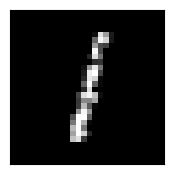

In [11]:
visualize(model)

# Question 2: Autoencoders (5 points)

For this question you will be implementing an autoencoder to compress the MNIST dataset.
You may use `torch.autograd` and `torch.nn` for this question.

1. (1 points) Implement the encoder.
Your encoder computes $\operatorname{Encoder}(\mathbf{x}) = \operatorname{ReLU}(\mathbf{W} \mathbf{x} + \mathbf{b})$.

2. (1 points) Implement the decoder. Your decoder computes $\operatorname{Decoder}(\mathbf{x}) = \operatorname{Sigmoid}(\mathbf{W} \mathbf{x} + \mathbf{b})$,
where we use the sigmoid function to match the pixel range $(0, 1)$.

3. (3 points) Implement `train_autoencoder` that trains the autoencoder on MNIST.


In [14]:
class Encoder(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()

        # Start of the implementation
        self.fc = nn.Linear(in_dim, out_dim)
        self.relu = nn.ReLU()
        # End of the implementation

    def forward(self, x):
        # Start of the implementation
        x = self.relu(self.fc(x))
        return x
        # End of the implementation

class Decoder(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()

        # Start of the implementation
        self.fc = nn.Linear(in_dim, out_dim)
        self.sigmoid = nn.Sigmoid()
        # End of the implementation

    def forward(self, x):
        # Start of the implementation
        x = self.sigmoid(self.fc(x))
        return x
        # End of the implementation

Implement the training code of the autoencoder.
Your training code should print the training mean squared error (MSE) loss in every epoch.

In [20]:
def train_autoencoder(encoder, decoder, optimizer, train_loader, epoch):
    encoder.train()
    decoder.train()

    # We use the mean squared error loss
    criterion = nn.MSELoss()

    # Start of the implementation
    for i in range(epoch):
      losses = []
      for j, (input, label) in enumerate(train_loader, 0):
        input = input.view(-1, 28 * 28)
        optimizer.zero_grad()
        encode = encoder(input)
        decode = decoder(encode)
        loss = criterion(decode, input)
        losses.append(loss)
        loss.backward()
        optimizer.step()
      print("Epoch",i," training error:",torch.mean(torch.tensor(losses)).item())
    # End of the implementation

def visualize_autoencoder(encoder, decoder):
    idx = torch.randint(high=10000, size=(1,)).item()

    print("image index {:d}".format(idx))

    img = test_set.data[idx]
    x = img.flatten().float()

    fig, axes = plt.subplots(1, 2, figsize=(4, 8))

    axes[0].imshow(x.reshape(28, 28), cmap='gray')
    axes[0].set_title('original image')
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    axes[1].imshow(decoder(encoder(x)).detach().numpy().reshape(28, 28), cmap='gray')
    axes[1].set_title('reconstructed')
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    plt.show()

Let's initialize the autoencoder and visualize its reconstruction.
As the autoencoder is not trained, the reconstructed image is random noise.

image index 2643


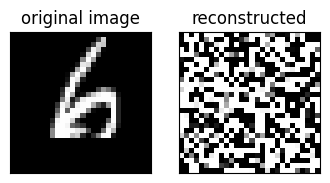

In [16]:
encoder = Encoder(784, 50)
decoder = Decoder(50, 784)

visualize_autoencoder(encoder, decoder)

Train the autoencoder for 10 epochs.
The training should finish in 2 min.

In [21]:
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

train_autoencoder(encoder, decoder, optimizer, train_loader, epoch=10)

Epoch 0  training error: 0.03588491678237915
Epoch 1  training error: 0.02809419110417366
Epoch 2  training error: 0.022945037111639977
Epoch 3  training error: 0.019531382247805595
Epoch 4  training error: 0.017173809930682182
Epoch 5  training error: 0.015419204719364643
Epoch 6  training error: 0.014039111323654652
Epoch 7  training error: 0.012929492630064487
Epoch 8  training error: 0.012017936445772648
Epoch 9  training error: 0.011290800757706165


Visualize the reconstructed image after training.
The reconstruction should mimic the original image.

image index 3149


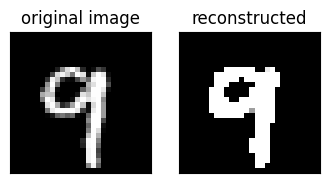

In [24]:
visualize_autoencoder(encoder, decoder)

# Question 3: Neural Network Backpropagation (10 points)

For this question, implement and train a fully connected neural network **without** using `torch.autograd` and `torch.nn`.

1. (2 points) Implement the `foward` function in the `NetworkNoAutograd` class.
Similar to Q1, this is an one-hidden-layer ReLU network: $f(\mathbf{x}) = \mathbf{W}_2 \operatorname{ReLU}(\mathbf{W}_1\mathbf{x})$.
    - Do not apply the softmax function when implementing the `forward` function, since this function computes the **pre-softmax** logits.
    - To make this question simpler, we have omitted the bias $\mathbf{b}_1$ and $\mathbf{b}_2$. Thus, the neural network is slightly different from the one in Q1.
    - `torch.nn` is **not** allowed. For example, you cannot use `nn.Linear` to implement the `forward` function.
2. (4 points) Implement the `backward` function in `NetworkNoAutograd`.
3. (3 points) Implement the `backward_cross_entropy` function. This function computes the gradient of the cross entropy loss.
4. (1 points) Implement the `SGD.step` function -- the update rule of the stochastic gradient descent.

You are encouraged to use `torch.autograd` to numerically verify your solution and help you debug.
However, `torch.autograd` (including `tensor.backward`) cannot be used in the final submission.
You must implement the backpropagation manually.
**If you use `torch.autograd` to pass the autograder, you will get 0 mark for this question.**

In [25]:
import math

def get_initialization(in_features, out_features):
    return torch.empty(in_features, out_features).uniform_(
        -1. / math.sqrt(in_features), 1. / math.sqrt(in_features)
    )

class NetworkNoAutograd(object):
    def __init__(self, in_dim, hidden, out_dim):
        super().__init__()

        self.w1 = get_initialization(in_dim, hidden)
        self.w2 = get_initialization(hidden, out_dim)

        self.d_w1 = torch.zeros_like(self.w1)
        self.d_w2 = torch.zeros_like(self.w2)

        # self.x is a tensor of size (batch, d), which caches the input data in the current forward pass
        # It will be used in self.backward
        self.x = None

        # self.activation is a tensor of size (batch, hidden), which caches the intermediate activations of the hidden neurons.
        # It will be used in self.backward
        self.activation = None

    def forward(self, x):
        # Start of the implementation
        self.x = x
        h = x @ self.w1
        self.activation = torch.maximum(torch.zeros_like(h), h)
        out = self.activation @ self.w2
        return out
        # End of the implementation

    def backward(self, d_logits):
        """
        Given d_logits, compute the gradient self.d_w1 and self.d_w2 manually.

        Args:
            d_logits: a tensor of size (batch, num_classes). This is the returned tensor of backward_cross_entropy(logits, y).

        Returns:
            None, you should store the gradient in self.d_w1 and self.d_w2

        Hint:
            1. Suppose a = ReLU(z). Then the derivative of ReLU is (a > 0).float()
        """

        # Start of the implementation
        self.d_w2 = self.activation.T @ d_logits
        d_hidden = d_logits @ self.w2.T
        d_hidden[self.activation <= 0] = 0
        self.d_w1 = self.x.T @ d_hidden
        # End of the implementation

    @property
    def parameters(self):
        return [self.w1, self.w2]

    @property
    def gradients(self):
        return [self.d_w1, self.d_w2]

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def eval(self):
        """This function is intentionally blank."""
        pass

Now let's implement the gradient of the cross entropy loss.

Consider a multi-class classification problem with $c$ labels.
Let $y \in \{1, 2, \cdots, c\}$ be the ground truth label.
Let $\mathbf{z} = (\begin{matrix} z_1 & z_2 & \cdots & z_c\end{matrix})^\top \in \mathbb{R}^{c}$ be the output of the neural network.
The cross entropy loss $\ell$ is defined as
<!-- \operatorname{CrossEntropy}(\mathbf{z}, y) & -->
\begin{align}
\ell(\mathbf{z}, y) & = - \log \bigg(\frac{\exp(z_y)}{\sum_{i = 1}^{c} \exp(z_i)}\bigg) \\
& = - z_y + \log \sum_{i = 1}^{c} \exp(z_i)
\end{align}
where $z_y$ is the $y$-th entry in $\mathbf{z}$.
<!-- When $c = 2$, the cross entropy loss reduces to the logistic loss (left as an excercise). -->

Our goal is to compute the derivative $\frac{d}{d \mathbf{z}} \ell$. Hint: for each entry $\frac{\partial}{\partial z_i} \ell$ where $1 \leq i \leq c$, discuss two cases $i = y$ and $i \neq y$.

In [26]:
def cross_entropy(logits, y):
    """
    Compute the cross entropy loss given the output of the neural network and the labels.

    This function is tricky as it requires the log-sum-exp trick to enhance its numerical stability.
    Thus, the TA has already implemented it for you.
    """
    batch, c = logits.size()

    maxi = logits.max(dim=-1, keepdim=True).values
    loss = torch.sum(logits * F.one_hot(y, c), dim=-1).neg() + maxi + (logits - maxi).exp().sum(dim=-1).log()
    return loss.mean()

def one_hot(y, num_classes):
    """
    A helper function that computes the one hot encoding.

    Args:
        y: a tensor of size (batch,) representing the labels
        num_classes: int

    Returns:
        A tensor of size (batch, num_classes) that represents the one hot encoding of the labels.
    """
    classes = torch.arange(num_classes, dtype=torch.long)
    return (y.unsqueeze(-1) == classes.unsqueeze(-2)).long()

def backward_cross_entropy(logits, y):
    """
    Compute the backward pass of the cross entropy loss -- the gradient of the CE loss with respect to the logits.

    Args:
        logits: a tensor of size (batch, c). The output of the neural network.
        y: a tensor of size (batch,). The labels.

    Returns:
        The gradient of the cross entropy loss with respect to the logits.
        The return type is a tensor of size (batch, c) -- the same size as the logits.

    Hint:
        1. You may find `one_hot` function useful.
        2. The cross entropy loss is averged over the batch. Thus, you may need to normalize the gradient.
    """
    # Start of the implementation
    batch, c = logits.shape
    one_hot_encode = one_hot(y, c)
    grad = (-one_hot_encode + torch.softmax(logits, dim=1)) / batch
    return grad
    # End of the implementation

One of the TAs is kind enough to include the following code that helps you debug.

In [27]:
def _debug():
    # initialize a smaller neural network
    model3 = NetworkNoAutograd(10, 5, 3)

    # synthetic data
    x = torch.randn(4, 10)
    y = torch.tensor([0, 1, 2, 0], dtype=torch.long)

    # temporarily enable autograd
    model3.w1.requires_grad_()
    model3.w2.requires_grad_()

    logits = model3(x)
    loss = cross_entropy(logits, y)

    loss.backward()

    with torch.no_grad():
        d_logits = backward_cross_entropy(logits, y)
        model3.backward(d_logits)

    # compare the manually calculated gradient with autograd
    # if your implementation is correct, the following difference is usually smaller than 1e-6
    print((model3.d_w1 - model3.w1.grad).abs().max())
    print((model3.d_w2 - model3.w2.grad).abs().max())

# uncomment the following line to verify your backward pass implementation
_debug()

tensor(2.2352e-08)
tensor(1.4901e-08)


Next, we implement the update rule of the (stochastic) gradient descent.

In [28]:
class SGD(object):
    def __init__(self, model, eta):
        super().__init__()

        self.model = model  # the model that SGD is going to optimize
        self.eta = eta  # the step size (learning rate)

    def step(self):
        for param, grad in zip(self.model.parameters, self.model.gradients):
            # We loop over all parameters and gradients in the model.
            # Use the grad to update the param.

            # Start of the implementation
            param -= self.eta * grad
            # End of the implementation

In [29]:
@torch.no_grad()
def train_no_autograd(model, optimizer, train_loader, test_loader, epoch=20):
    """We have already implemented the training code for you."""
    for i in range(epoch):
        total_loss = 0.
        correct = 0.

        for x, y in train_loader:
            logits = model(x)
            loss = cross_entropy(logits, y)

            d_logits = backward_cross_entropy(logits, y)
            model.backward(d_logits)

            optimizer.step()

            total_loss += loss.item()
            correct += logits.argmax(dim=-1).eq(y).sum()

        # print the statistics
        train_loss = total_loss / len(train_loader)
        train_acc = correct / 60000.

        test_acc = evaluate(model, test_loader)
        print(
            "epoch {:3d}/{:3d},".format(i + 1, epoch),
            "train loss {:f},".format(train_loss),
            "train acc {:f},".format(train_acc),
            "test acc {:f}".format(test_acc),
        )

Let's train the neural network. You should be able to get about 93% test accuracy.
The accuracy is slightly lower than the one in Q1.
This is expected due to two reasons: (a) we have omitted the bias term and (b) the optimizer is the vannila stochastic gradient descent, which converges slower than the Nesterov's accelerated version.
Though, this model is already good enough for the purpose of this question.

In [30]:
model3 = NetworkNoAutograd(784, 100, 10)

optimizer = SGD(model3, eta=0.1)
train_no_autograd(model3, optimizer, train_loader, test_loader, epoch=20)

acc_train_set = evaluate(model3, train_loader)
acc_test_set = evaluate(model3, test_loader)

print("training set acc {:f}, test set acc {:f}".format(acc_train_set, acc_test_set))

epoch   1/ 20, train loss 1.606463, train acc 0.657017, test acc 0.823200
epoch   2/ 20, train loss 0.676818, train acc 0.844000, test acc 0.872700
epoch   3/ 20, train loss 0.486271, train acc 0.874783, test acc 0.889000
epoch   4/ 20, train loss 0.417299, train acc 0.887117, test acc 0.897400
epoch   5/ 20, train loss 0.380781, train acc 0.894583, test acc 0.901800
epoch   6/ 20, train loss 0.357343, train acc 0.899950, test acc 0.907000
epoch   7/ 20, train loss 0.340393, train acc 0.903933, test acc 0.910500
epoch   8/ 20, train loss 0.326759, train acc 0.907433, test acc 0.912400
epoch   9/ 20, train loss 0.315516, train acc 0.910783, test acc 0.916900
epoch  10/ 20, train loss 0.305111, train acc 0.913233, test acc 0.917200
epoch  11/ 20, train loss 0.296456, train acc 0.916100, test acc 0.920700
epoch  12/ 20, train loss 0.287583, train acc 0.918700, test acc 0.923200
epoch  13/ 20, train loss 0.280118, train acc 0.920933, test acc 0.924100
epoch  14/ 20, train loss 0.272910, tr

image index 7908
prediction 7


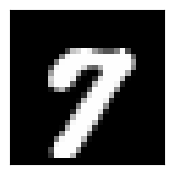

In [31]:
visualize(model3)

#Autograder

In [32]:
from penngrader.grader import PennGrader

# PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO
# TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 72249835 # YOUR PENN-ID GOES HERE AS AN INTEGER #
SECRET = STUDENT_ID

grader = PennGrader('config.yaml', 'CIS5200_FALL_2023_HW4', STUDENT_ID, SECRET)


grader.grade(test_case_id = 'nn_forward', answer = Network)
grader.grade(test_case_id = 'nn_evaluate', answer = evaluate)
grader.grade(test_case_id = 'nn_train', answer = train)

grader.grade(test_case_id = 'en_forward', answer = Encoder)
grader.grade(test_case_id = 'de_forward', answer = Decoder)
grader.grade(test_case_id = 'train_autoencoder', answer = train_autoencoder)

grader.grade(test_case_id = 'nograd_forward', answer = NetworkNoAutograd)
grader.grade(test_case_id = 'nograd_backward', answer = NetworkNoAutograd)
grader.grade(test_case_id = 'backward_cross_entropy', answer = backward_cross_entropy)
grader.grade(test_case_id = 'backward_sgd', answer = SGD)

PennGrader initialized with Student ID: 72249835

Make sure this correct or we will not be able to store your grade
Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 4/4 points. You are a star!

Your submission has been successfully